In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import torch
import numpy as np
import pandas as pd


In [3]:
from src.utils.logger import Logging

from src.nn.tanh2 import MLP2
from src.nn.bspline import KAN
from src.nn.kan2 import KAN2
from src.utils.utils import clear_gpu_memory
from src.data.IBM_data_loader import prepare_training_data, visualize_tensor_datasets
from src.data.IBM_data_loader import load_training_dataset, load_fluid_testing_dataset
from src.models.m1 import PINNTrainer
from src.utils.plot_losses import plot_M1_loss_history
from src.utils.fsi_visualization import (
    create_frames,
    create_animations_from_existing_frames,
)


In [4]:
CHECKPOINT_PATH = "./checkpoints"
logger = Logging(CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(model_dirname)


INFO:src.utils.logger:./checkpoints/2025-05-02_19-08-50-016632


In [5]:
clear_gpu_memory()
config = {
    # Data parameters
    "dataset_type": "old",
    "training_selection_method": "Sobol",
    # Model parameters
    "input_dim": 3,  # (x, y, z, t)
    "hidden_dim": 50,
    "hidden_layers_dim": 3,
    # Physics parameters
    "fluid_density": 1.0,
    "fluid_viscosity": 0.01,
    # Training parameters
    "num_epochs": 10000,
    "batch_size": 265,
    "learning_rate": 1e-3,
    # Loss weights
    "data_weight": 2.0,
    "physics_weight": 0.015,
    "boundary_weight": 2.0,
    "fsi_weight": 0.5,
    "initial_weight": 2.0,
    # Checkpoint parameters
    "checkpoint_dir": "./checkpoints",
    "resume": None,
    "print_every": 100,
    "save_every": 500,
    # Data sampling parameters
    "fluid_sampling_ratio": 0.005,
    "interface_sampling_ratio": 0.07,
    "solid_sampling_ratio": 0.03,
    "left_sampling_ratio": 0.1,
    "right_sampling_ratio": 0.15,
    "bottom_sampling_ratio": 0.1,
    "top_sampling_ratio": 0.1,
    "initial_sampling_ratio": 0.1,
    # Device parameters
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "solver": "mlp",
    "model": "m1",
}


GPU memory cleared!


In [6]:
## print the config
logger.print("Config:")
for key, value in config.items():
    logger.print(f"{key}: {value}")


INFO:src.utils.logger:Config:
INFO:src.utils.logger:dataset_type: old
INFO:src.utils.logger:training_selection_method: Sobol
INFO:src.utils.logger:input_dim: 3
INFO:src.utils.logger:hidden_dim: 50
INFO:src.utils.logger:hidden_layers_dim: 3
INFO:src.utils.logger:fluid_density: 1.0
INFO:src.utils.logger:fluid_viscosity: 0.01
INFO:src.utils.logger:num_epochs: 10000
INFO:src.utils.logger:batch_size: 265
INFO:src.utils.logger:learning_rate: 0.001
INFO:src.utils.logger:data_weight: 2.0
INFO:src.utils.logger:physics_weight: 0.015
INFO:src.utils.logger:boundary_weight: 2.0
INFO:src.utils.logger:fsi_weight: 0.5
INFO:src.utils.logger:initial_weight: 2.0
INFO:src.utils.logger:checkpoint_dir: ./checkpoints
INFO:src.utils.logger:resume: None
INFO:src.utils.logger:print_every: 100
INFO:src.utils.logger:save_every: 500
INFO:src.utils.logger:fluid_sampling_ratio: 0.005
INFO:src.utils.logger:interface_sampling_ratio: 0.07
INFO:src.utils.logger:solid_sampling_ratio: 0.03
INFO:src.utils.logger:left_sampl

In [8]:
training_data_path = "./data/training_dataset/old"

# Load data

training_data = (
    None  # load_training_dataset(training_data_path, device=config["device"])
)
# print(f"Training data type: {training_data[list(training_data.keys())[0]].dtype}")

if training_data is None:
    training_data = prepare_training_data(
        dataset_type=config["dataset_type"],
        fluid_sampling_ratio=config["fluid_sampling_ratio"],
        interface_sampling_ratio=config["interface_sampling_ratio"],
        solid_sampling_ratio=config["solid_sampling_ratio"],
        left_sampling_ratio=config["left_sampling_ratio"],
        right_sampling_ratio=config["right_sampling_ratio"],
        bottom_sampling_ratio=config["bottom_sampling_ratio"],
        top_sampling_ratio=config["top_sampling_ratio"],
        initial_sampling_ratio=config["initial_sampling_ratio"],
        training_selection_method=config["training_selection_method"],
        device=config["device"],
        save_dir=training_data_path,
    )


visualize_tensor_datasets(training_data, save_dir=training_data_path)


Saved fluid tensor with shape torch.Size([5254, 8]) to ./data/training_dataset/old/fluid_tensor.pt
Saved fluid_points tensor with shape torch.Size([1993, 8]) to ./data/training_dataset/old/fluid_points_tensor.pt
Saved interface tensor with shape torch.Size([1781, 8]) to ./data/training_dataset/old/interface_tensor.pt
Saved solid tensor with shape torch.Size([4356, 8]) to ./data/training_dataset/old/solid_tensor.pt
Saved left tensor with shape torch.Size([1030, 8]) to ./data/training_dataset/old/left_tensor.pt
Saved right tensor with shape torch.Size([1545, 8]) to ./data/training_dataset/old/right_tensor.pt
Saved bottom tensor with shape torch.Size([1030, 8]) to ./data/training_dataset/old/bottom_tensor.pt
Saved up tensor with shape torch.Size([1030, 8]) to ./data/training_dataset/old/up_tensor.pt
Saved initial tensor with shape torch.Size([1330, 8]) to ./data/training_dataset/old/initial_tensor.pt
Saved tensor datasets scatter plot to ./data/training_dataset/old/tensor_datasets_scatter

In [42]:
interface = training_data["right"]

interface

tensor([[0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 1.0000, 0.5000,  ..., 0.0499, 0.0000, 0.0000],
        [0.7500, 1.0000, 0.7500,  ..., 0.1181, 0.0000, 0.0000],
        ...,
        [0.6300, 1.0000, 0.3700,  ..., 0.0397, 0.0000, 0.0000],
        [0.1200, 1.0000, 0.8700,  ..., 0.2013, 0.0000, 0.0000],
        [0.1900, 1.0000, 0.1800,  ..., 0.0138, 0.0000, 0.0000]],
       device='cuda:0')

In [35]:
fluid_network = (
    [config["input_dim"]] + [config["hidden_dim"]] * config["hidden_layers_dim"] + [3]
)
if config["solver"] == "mlp":
    fluid_model = MLP2(network=fluid_network)
else:
    fluid_model = KAN2(network=fluid_network)

logger.print("Fluid model architecture:")
logger.print(fluid_model)
logger.print(
    f"Number of parameters: {sum(p.numel() for p in fluid_model.parameters())}"
)


INFO:src.utils.logger:Fluid model architecture:
INFO:src.utils.logger:MLP2(
  (activation): Tanh()
  (shared_layers): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
  )
  (velocity_branch): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
  (pressure_branch): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)
INFO:src.utils.logger:Number of parameters: 20703


In [36]:
# Create trainer
trainer = PINNTrainer(
    fluid_model=fluid_model,
    training_data=training_data,
    learning_rate=config["learning_rate"],
    logger=logger,
    device=config["device"],
    fluid_density=config["fluid_density"],
    fluid_viscosity=config["fluid_viscosity"],
    print_every=config["print_every"],
    save_every=config["save_every"],
    solver=config["solver"],
    model=config["model"],
)


# Train model
loss_history = trainer.train(
    num_epochs=config["num_epochs"],
    batch_size=config["batch_size"],
    data_weight=config["data_weight"],
    physics_weight=config["physics_weight"],
    boundary_weight=config["boundary_weight"],
    fsi_weight=config["fsi_weight"],
    initial_weight=config["initial_weight"],
)


/home/vlq26735/anaconda3/envs/pinn_ibm4fsi/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:src.utils.logger:Epoch 100/10000, Total: 1.3e+00, Data: 1.1e-01, Physics: 2.2e-02, Boundary: 9.8e-01, FSI: 1.8e-01, Initial: 6.0e-02, LR: 1.00e-03
INFO:src.utils.logger:Epoch 200/10000, Total: 1.0e+00, Data: 6.8e-02, Physics: 2.7e-02, Boundary: 7.1e-01, FSI: 1.4e-01, Initial: 6.0e-02, LR: 1.00e-03
INFO:src.utils.logger:Epoch 300/10000, Total: 8.7e-01, Data: 5.6e-02, Physics: 3.0e-02, Boundary: 6.1e-01, FSI: 1.3e-01, Initial: 5.5e-02, LR: 1.00e-03
INFO:src.utils.logger:Epoch 400/10000, Total: 8.2e-01, Data: 5.0e-02, Physics: 3.2e-02, Boundary: 5.6e-01, FSI: 1.2e-01, Initial: 6.3e-02, LR: 1.00e-03
INFO:src.utils.logger:Epoch 500/10000, Total: 7.7e-01, Data: 4.9e-02, Physics: 3.3e-02, Boundary: 5.3e-

KeyboardInterrupt: 

INFO:src.utils.logger:Number of parameters: 984903
/home/vlq26735/saiful/afrah/code/pinn_ibm4fsi2/src/utils/plot_losses.py:139: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=y_min)


final loss BC: 1.52e-01
final loss Data: 4.07e-02
final loss FSI: 8.31e-02
final loss Initial: 2.97e-02
final loss Total: 3.19e-01


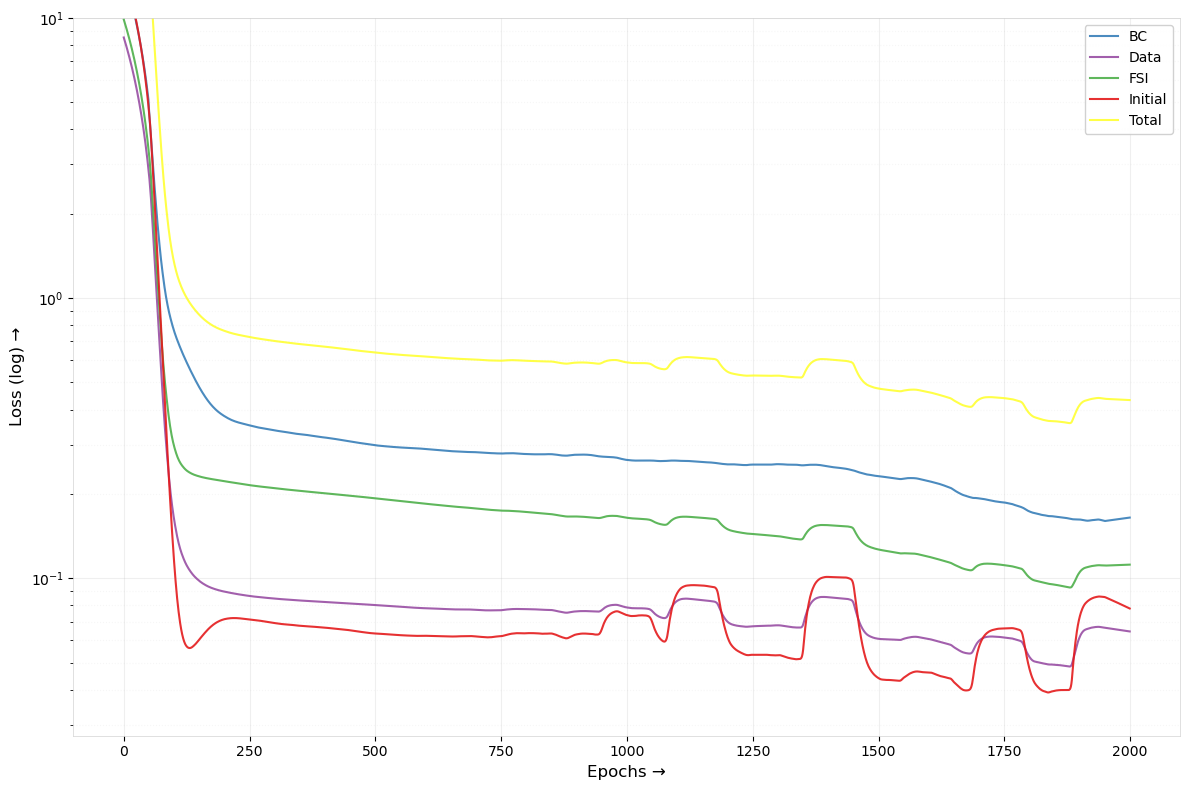

In [37]:
model_path = "./checkpoints/2025-05-02_08-49-43-033212/model.pth"  # os.path.join(trainer.logger.get_output_dir(), "model.pth")
model_state = torch.load(model_path)

solver = model_state["solver"]
if solver == "mlp":
    fluid_model = MLP2(model_state["fluid_network"]).to("cpu")
else:
    fluid_model = KAN2(model_state["fluid_network"]).to("cpu")


fluid_model.load_state_dict(model_state["fluid_model_state_dict"])

fluid_model.eval()

logger.print(
    f"Number of parameters: {sum(p.numel() for p in fluid_model.parameters())}"
)

loss_history = model_state["loss_history"]

save_path = os.path.join(logger.get_output_dir(), "loss_history_M1.png")

plot_M1_loss_history(loss_history, save_path, y_max=10, y_min=0, figsize=(12, 8))


In [38]:
animations_reference_dir = os.path.join(logger.get_output_dir(), "animations_reference")


try:
    testing_dataset = load_fluid_testing_dataset(config["dataset_type"])
except Exception as e:
    logger.print(f"Testing dataset not found")
    raise e

skip = 1
time = testing_dataset[:, 0:1][::skip]
x = testing_dataset[:, 1:2][::skip]
y = testing_dataset[:, 2:3][::skip]
u_ref = testing_dataset[:, 3:4][::skip]
v_ref = testing_dataset[:, 4:5][::skip]
p_ref = testing_dataset[:, 5:6][::skip]


In [39]:
with torch.no_grad():
    outputs = fluid_model(torch.cat([time, x, y], dim=1).squeeze(1))

u_pred = outputs[:, 0:1]
v_pred = outputs[:, 1:2]
p_pred = outputs[:, 2:3]


velocity_magnitude_pred = torch.sqrt(u_pred**2 + v_pred**2)

rel_u_l2_error = (
    torch.sqrt(torch.mean((u_pred - u_ref) ** 2) / torch.mean(u_ref**2)) * 100
)
rel_v_l2_error = (
    torch.sqrt(torch.mean((v_pred - v_ref) ** 2) / torch.mean(v_ref**2)) * 100
)
rel_p_l2_error = (
    torch.sqrt(torch.mean((p_pred - p_ref) ** 2) / torch.mean(p_ref**2)) * 100
)

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


INFO:src.utils.logger:Relative L2 error for u: 5.90e+01 %
INFO:src.utils.logger:Relative L2 error for v: 6.63e+01 %
INFO:src.utils.logger:Relative L2 error for p: 1.21e+02 %


In [ ]:
INFO:src.utils.logger:Relative L2 error for u: 7.89e+01 %
INFO:src.utils.logger:Relative L2 error for v: 7.39e+01 %
INFO:src.utils.logger:Relative L2 error for p: 1.07e+02 %

In [46]:
animations_pred_dir = os.path.join(logger.get_output_dir(), "animations_pred")

prediction_df = pd.DataFrame(
    {
        "time": time.detach().numpy().flatten(),
        "x": x.detach().numpy().flatten(),
        "y": y.detach().numpy().flatten(),
        "pressure": p_pred.detach().numpy().flatten(),
        "u_x": u_pred.detach().numpy().flatten(),
        "v_y": v_pred.detach().numpy().flatten(),
        "velocity_magnitude": np.sqrt(
            u_pred.detach().numpy().flatten() ** 2
            + v_pred.detach().numpy().flatten() ** 2
        ),
    }
)

create_frames(prediction_df, output_dir=animations_pred_dir, sample_rate=10)


  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/pressure
  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/velocity_magnitude
  Processing time step 0.00 (1/11)
  Processing time

In [47]:
testing_df = pd.DataFrame(
    {
        "time": time.detach().numpy().flatten(),
        "x": x.detach().numpy().flatten(),
        "y": y.detach().numpy().flatten(),
        "pressure": p_ref.detach().numpy().flatten(),
        "u_x": u_ref.detach().numpy().flatten(),
        "v_y": v_ref.detach().numpy().flatten(),
        "velocity_magnitude": np.sqrt(
            u_ref.detach().numpy().flatten() ** 2
            + v_ref.detach().numpy().flatten() ** 2
        ),
    }
)
create_frames(testing_df, output_dir=animations_reference_dir, sample_rate=10)


  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/pressure
  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/velocity_magnitude
  Processing time step 0.00 (1/11)
  Proce

In [48]:
create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_reference_dir, "pressure"),
        os.path.join(animations_reference_dir, "u_x"),
        os.path.join(animations_reference_dir, "v_y"),
        os.path.join(animations_reference_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_reference_dir, "gif"),
)


Found 11 frames for pressure
Creating animation for pressure...
Saving animation to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/gif/pressure_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/gif/pressure_animation.gif
Found 11 frames for u_x
Creating animation for u_x...
Saving animation to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/gif/u_x_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/gif/u_x_animation.gif
Found 11 frames for v_y
Creating animation for v_y...
Saving animation to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/gif/v_y_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-05-01_11-06-58-802444/animations_reference/gif/v_y_animation.gif
Found 11 frames for velocity_magnitude
Creating animation for velocity_magnitude...
Saving animation to ./checkpoints/2025-05-01_11

In [49]:
create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_pred_dir, "pressure"),
        os.path.join(animations_pred_dir, "u_x"),
        os.path.join(animations_pred_dir, "v_y"),
        os.path.join(animations_pred_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_pred_dir, "gif"),
)


Found 11 frames for pressure
Creating animation for pressure...
Saving animation to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/gif/pressure_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/gif/pressure_animation.gif
Found 11 frames for u_x
Creating animation for u_x...
Saving animation to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/gif/u_x_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/gif/u_x_animation.gif
Found 11 frames for v_y
Creating animation for v_y...
Saving animation to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/gif/v_y_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/gif/v_y_animation.gif
Found 11 frames for velocity_magnitude
Creating animation for velocity_magnitude...
Saving animation to ./checkpoints/2025-05-01_11-06-58-802444/animations_pred/